# NLP Assignment 2 (40% of grade): Vector Space Semantics for Similarity between Eastenders Characters

In this assignment, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

As the lines are not evenly distributed in terms of frequency, this coursework stipulates you can only use a maximum of the first **400 lines** of each character in the training data `training.csv` to create the training documents, and a maximum of the first **40 lines** in the test data (from `test.csv`). This makes it more challenging, as number of lines spoken by a character can't be used directly or otherwise as a feature.

A simple vector representation for each character document is done for you to start with in this code, as is the pipeline of similarity-based information retrieval based evaluation. You need to improve the character vector representations by pre-processing, feature extraction and transformation techniques, as per Questions 1-6 below, which you need to complete as instructed.

**Refer to the material in units 8-9 for conceptual background.**

# Q5. Improve the vectorization method (20 marks)
Use a matrix transformation technique like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizor (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

As the `create_document_matrix_from_corpus` is designed to be used both in training/fitting (with `fitting` set to `True`) and in transformation alone on test/validation data (with `fitting` set to `False`), make sure you initialize any transformers you want to try in the same place as `corpusVectorizer = DictVectorizer()` before you call 
`create_document_matrix_from_corpus`. Again, develop on 90% training 10% validation split and note the effect/improvement in mean rank with each technique you try.

# Q6. Run on final test data  (10 marks)

In [1]:
!pip install nltk

In [2]:
pip install num2words

Note: you may need to restart the kernel to use updated packages.


In [3]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

# additional imports for preprocesssing
from string import punctuation

# to lemmatise words
from nltk.stem import WordNetLemmatizer 

# for stemming
from nltk.stem import PorterStemmer

# used to iterate on true and false for pre-processing
from itertools import product
import pandas as pd

from num2words import num2words

In [4]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

In [5]:
# Split into training and test data for heldout validation with random samples of 9:1 train/heldout split
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column

# 1350-1 1350-2 --> sorted
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

# after sorting, shuffled
shuffle(episode_scenes)

print(f'total number of of episode scenes -> {len(episode_scenes)}')
episode_split = int(0.9*len(episode_scenes))

# 90% of the data to the training set, 0 to 90% border
training_ep_scenes = episode_scenes[:episode_split]
# 10% of the data to the test set, from 90% to 100% border
test_ep_scenes = episode_scenes[episode_split:]
print(f'Total number of training episode scenes -> {len(training_ep_scenes)}\nTotal number of episode test episode scenes -> {len(test_ep_scenes)}')

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

# adding a new column to identify if data is in training set or heldout (test set)
all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

total number of of episode scenes -> 1394
Total number of training episode scenes -> 1254
Total number of episode test episode scenes -> 140


In [6]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [7]:
# Inspect
print('---- Raw Data ----')
all_train_data

---- Raw Data ----


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [8]:
print('---- Train Data ----')
train_data

---- Train Data ----


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [9]:
print('---- Val Data ----')
val_data

---- Val Data ----


,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
56,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,Who's that?,FEMALE,1350-18,heldout
57,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,Tanya! Tanya it's me. I wanna give Oscar a New Year kiss. Tan?,MALE,1350-18,heldout
58,1350,18,BRANNINGS' HOUSE INT NIGHT,SEAN,Right. I'll have a word.,MALE,1350-18,heldout
59,1350,18,BRANNINGS' HOUSE INT NIGHT,TANYA,"No no no leave it, leave it. He ain't got a key. He'll go away. Do you want some crisps?",FEMALE,1350-18,heldout
60,1350,18,BRANNINGS' HOUSE INT NIGHT,MAX,"Who, who you got in there, Tan? Tan, I've got a right to know who my kids are being exposed to. I bet you ain't got anyone have ya? You're just sitting there with a bottle of wine all on your Jack, Tan?",MALE,1350-18,heldout
...,...,...,...,...,...,...,...,...
15268,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"I asked him to leave you. I asked him again and again. I begged him. And if he had. I'd have been with him. I'd have been with him now. So it might suit you to think that it was all Max but it wasn't, not really, not in the end.",FEMALE,1399-29,heldout
15269,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,Why you telling me all this eh?,FEMALE,1399-29,heldout
15270,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,STACEY,"Because I don't want you using Sean to punish him, I don't want you wrecking your family cause of me. I just, I just want it all over.",FEMALE,1399-29,heldout
15271,1399,29,[NAME] & [NAME]'S HOUSE INT NIGHT,TANYA,It is over. It's all over. Will you please just go home now and leave me alone.,FEMALE,1399-29,heldout


In [10]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    # may be left out
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [11]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    episode_scene_list = []
    character_in_episode_list = []
    characters_list = []
    
    # get all characters
    for line, name in zip(df.Line, df.Character_name):
        if name not in characters_list:
            characters_list.append(name)
            
    for line, name, gender, ep_sc in zip(df.Line, df.Character_name, df.Gender, df.episode_scene):
        
        episode_character = []
        
        if(dialogue_context_invest['is_ep_sc_include']):
            # for new episodes
            if len(episode_scene_list) != 0 and ep_sc != episode_scene_list[-1]:
                for character in characters_list:
                    if not character in character_docs.keys():
                        character_docs[character] = ""
                        character_line_count[character] = 0

                    if character not in character_in_episode_list:
                        character_docs[character] += " _N"+episode_scene_list[-1]+"N_ "
                        character_line_count[character] += 0
                character_in_episode_list = []
        
        # to reduce memory, avoid duplicates
        if name not in character_in_episode_list:                 
            character_in_episode_list.append(name) 
        
        if(dialogue_context_invest['is_ep_sc_include']):
            if ep_sc not in episode_scene_list:
                episode_scene_list.append(ep_sc)
                episode_character = []
        
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        
        if character_line_count[name]==max_line_count:
            continue
        
        
        if(dialogue_context_invest['is_ep_sc_include'] and dialogue_context_invest['is_gender_include']):
            character_docs[name] += f"_"+ep_sc+ f"_ _{gender}_ _SOL_ "+ str(line)   + " _EOL_ "  # adding start and end-of-line token
        elif(dialogue_context_invest['is_ep_sc_include']):
            character_docs[name] += f"_"+ep_sc+ f"_ _SOL_ "+ str(line)   + " _EOL_ "
        elif(dialogue_context_invest['is_gender_include']):
            character_docs[name] += f"_{gender}_ _SOL_ "+ str(line)   + " _EOL_ "
        else:
            character_docs[name] += f"_SOL_ "+ str(line)   + " _EOL_ "
            
        character_line_count[name]+=1
        
    print("lines per character", character_line_count)
    return character_docs

In [12]:
# convert number word texts to digits
# taken from https://github.com/ShailChoksi/text2digits
def text_to_digits(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    textnum = textnum.replace('-', ' ')

    current = result = 0
    curstring = ""
    onnumber = False
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
            current = current * scale + increment
            if scale > 100:
                result += current
                current = 0
            onnumber = True
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                if onnumber:
                    curstring += repr(result + current) + " "
                curstring += word + " "
                result = current = 0
                onnumber = False
            else:
                scale, increment = numwords[word]

                current = current * scale + increment
                if scale > 100:
                    result += current
                    current = 0
                onnumber = True

    if onnumber:
        curstring += repr(result + current)

    return curstring

In [13]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    tokens = []
    # skip episode scene and gender from pre-processing, insert directly to token
    character_text = character_text.split()
    if(dialogue_context_invest['is_ep_sc_include']):
        tokens_ep_sc = list(filter(lambda word: re.match(r'_\d{4}-\d{1,2}_',word), character_text))
        for t in tokens_ep_sc:
            tokens.append(t)
        tokens_ep_sc_n = list(filter(lambda word: re.match(r'_N\d{4}-\d{1,2}N_',word), character_text))
        for t in tokens_ep_sc_n:
            tokens.append(t)
    
    if(dialogue_context_invest['is_gender_include']):
        tokens_gender = list(filter(lambda word: re.match(r'_FEMALE_|_MALE_',word), character_text))
        for t in tokens_gender:
            tokens.append(t)
    
    character_text = list(filter(lambda word: word not in tokens, character_text))
    character_text = ' '.join(character_text)
    
    if(pre_process_invest['is_to_num_text_to_digits']):
        character_text = text_to_digits(character_text)
        character_text = re.sub(r'(\d+ )(dollars|dollar)',r'$\1',character_text) # convert 24 dollars to $24
        character_text = re.sub(r'(\d+ )(pounds|pound)',r'£\1',character_text) # convert 24 dollars to £24
        character_text = re.sub(r'(\d+ )(cents|cent)',r'$0.\1',character_text) # convert 24 cents to $0.24
        character_text = re.sub(r'(\d+ )(pence|penny)',r'£0.\1',character_text) # convert 24 pence to £0.24
    
     
    if(pre_process_invest['is_to_num_to_words']):
        character_text = re.sub(r'(\$)(\d+.\d+)',r'\2 dollars', character_text) # convert $0.2 to 0.2 dollars
        character_text = re.sub(r'(£)(\d+.\d+)',r'\2 pounds', character_text) # convert £0.2 to 0.2 pounds
        character_text = re.sub(r'(\d+)(.)(\d+)',r'\1 point \3', character_text) # convert 0.2 to 0 point 2
        character_text = re.sub(r'(\$)(\d+)',r'\2 dollars', character_text) # convert $50 to 50 dollars
        character_text = re.sub(r'(£)(\d+)',r'\2 pounds', character_text) # convert £50 to 50 pounds
        character_text = ''.join(map(str,[re.sub('(\d+)', lambda m: num2words(m.group()), text) for text in [character_text]]))

    
    if(pre_process_invest['is_replace_money_amount_to_money']):
        # convert '£100' to 'money'
        character_text = re.sub(r"(£|\$)\d+(?:\.\d+)?", "money", character_text)
    
    if(pre_process_invest['is_separate_punctuation_front_back_sentence']):
        # separate punctuation at the front and back of the sentence
        # note: this is still a text, not a token yet!
        character_text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", character_text) 
        character_text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", character_text)
    
    if(pre_process_invest['is_remove_punctuations'] == True):
        character_text = character_text.translate(str.maketrans('','',punctuation))
    
    if(pre_process_invest['is_replace_digits_to_num_hash']):
        # convert e.g. 21 to #
        character_text = re.sub('\d+', '#',character_text)
        
    if(pre_process_invest['is_to_lower_case']):
        # convert to lower case
        character_text = character_text.lower()
        
    ##### split white spaces, convert text to array of words
    char_text_split = character_text.split()
    for char_word in char_text_split:
        tokens.append(char_word)
    
    # change word to base root
    if(pre_process_invest['is_to_lemmatize']):
        tokens = [WordNetLemmatizer().lemmatize(token) for token in tokens]
    
    # removal of stop words such as a, the, is, are
    if(pre_process_invest['is_to_remove_stop_words']):
        stopword_list = nltk.corpus.stopwords.words('english')
        tokens = [token for token in tokens if token not in stopword_list] 
        
    return tokens

In [14]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """    
    counts = Counter()
    
    # replace EOL with </s> to know where sentence ends
    character_doc = ["</s>" if 'eol' in word.lower() else word for word in character_doc]
    # add <s> to know where sentence starts
    character_doc = ["<s>" if 'sol' in word.lower() else word for word in character_doc]
    
     # identify first <s> starts
    index_first_sol = character_doc.index('<s>')
    
    # just normaly count presence of episode scene and gender
    for i in range(index_first_sol):
        counts[character_doc[i]] += 1

    # collect the counts for all n in range (1,_N_)
    for n in range(1,feature_vector_invest['_N_gram_value_']+1):
        #new_tokens = ["<s>"]*(n-1) + character_doc
        new_tokens = character_doc
        for i in range(n-1, len(new_tokens)):
            #print(index_first_sol+i-(n-1))
            #raw_ngram = " ".join(new_tokens[i-(n-1):i+1])
            # apply n-grams from first sol onwards
            raw_ngram = " ".join(new_tokens[index_first_sol+i-(n-1):index_first_sol+i+1])
            #n_gram = f"{n}@{raw_ngram}"
            n_gram = f"{raw_ngram}"
            counts[n_gram]+=1
    
    # if _WEIGHT_ is 'counts' then this has already been done
    if feature_vector_invest['_weighing_technique_'] == "weighted":
        # bag-of-words counts 
        counts = {word:counts[word]/(len(character_doc)+1) for word in counts.keys()}

    #counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    countcount = 0
    for feature in extra_features:
        counts[feature] += 1      
    return counts  

In [15]:
corpusVectorizer = DictVectorizer()   # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline

tfidfTransformer = TfidfTransformer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])

    if(transformer_invest['isTfIdfTrans']):
        # using tfidfTransformer
        doc_feature_matrix = tfidfTransformer.fit_transform(doc_feature_matrix)
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

In [16]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [17]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ## similarity in  test and training, mean rank --> ranking each character or document with regards to training and testing data
    ## weighing and classification
    ## argmax = the one most similar
    ## rank, how far down the vector is at the correct character determined
    ## the lower the mean rank the better
    ## if the rank is 16 for all for each character --> the worst
    ######
    ## classification ranking ---> then get the total and get the mean = mean ranking
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    
    ## feature vector size, 
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    ###print("mean rank", np.mean(rankings))
    ###print("mean cosine similarity", mean_cosine_similarity)
    ###print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    ###print(df)
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [18]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [19]:
# using best pre-processing and feature extraction technique identified from question 1 and question 2
pre_process_invest = {'is_separate_punctuation_front_back_sentence': True,
 'is_to_num_text_to_digits': False,
 'is_remove_punctuations': True,
 'is_replace_money_amount_to_money': True,
 'is_replace_digits_to_num_hash': True,
 'is_to_lower_case': True,
 'is_to_lemmatize': True,
 'is_to_remove_stop_words': True,
 'is_to_num_to_words': False}

feature_vector_invest = {'_N_gram_value_': 1, '_weighing_technique_': 'counts'}

# from question 4
dialogue_context_invest = {'is_ep_sc_include': True, 'is_gender_include': True}

transformer_invest = {'isTfIdfTrans': False}

In [20]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
# there is 16 characters --> each character, only 360 lines recorded in training --> in total 5760 lines from training data (13638 lines)
print('--- Training set dataframe document ---')
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
ordered_train_docs = {}
for name in train_character_docs.keys():
    ordered_train_docs[name] = len(train_character_docs[name].split())
    total_words += len(train_character_docs[name].split())

ordered_train_docs = dict(sorted(ordered_train_docs.items(), key=lambda item: item[1]))
for name,word_len in ordered_train_docs.items():
    print(name, 'Number of Words: ',word_len)
print("total words", total_words)
print()

# get the validation data- only 40 lines used for each character
print('--- Validation set dataframe document ---')
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
ordered_val_docs = {}
for name in val_character_docs.keys():
    ordered_val_docs[name] = len(val_character_docs[name].split())
    total_words += len(val_character_docs[name].split())
ordered_val_docs = dict(sorted(ordered_val_docs.items(), key=lambda item: item[1]))
for name,word_len in ordered_val_docs.items():
    print(name, 'Number of Words: ',word_len)
print("total words", total_words)

--- Training set dataframe document ---
lines per character {'SHIRLEY': 360, 'OTHER': 360, 'JACK': 360, 'RONNIE': 360, 'TANYA': 360, 'SEAN': 360, 'ROXY': 360, 'HEATHER': 360, 'MAX': 360, 'IAN': 360, 'JANE': 360, 'STACEY': 360, 'PHIL': 360, 'MINTY': 360, 'CHRISTIAN': 342, 'CLARE': 352}
Num. Characters:  16 

OTHER Number of Words:  4795
RONNIE Number of Words:  5716
JANE Number of Words:  5897
PHIL Number of Words:  5916
SEAN Number of Words:  5921
TANYA Number of Words:  5941
CHRISTIAN Number of Words:  5993
SHIRLEY Number of Words:  6125
ROXY Number of Words:  6129
STACEY Number of Words:  6191
MINTY Number of Words:  6299
HEATHER Number of Words:  6387
IAN Number of Words:  6555
CLARE Number of Words:  6601
MAX Number of Words:  6605
JACK Number of Words:  6706
total words 97777

--- Validation set dataframe document ---
lines per character {'TANYA': 40, 'MAX': 40, 'SEAN': 35, 'SHIRLEY': 40, 'OTHER': 40, 'STACEY': 40, 'RONNIE': 40, 'JACK': 40, 'PHIL': 40, 'IAN': 40, 'JANE': 40, 'ROXY

In [21]:
transformer_invest_len = len(transformer_invest)

true_false = [False, True]

true_false_combi = product(true_false, repeat=transformer_invest_len)

df_transformer = pd.DataFrame(data = list(true_false_combi), columns=transformer_invest.keys())
df_transformer['mean_rank'] = ''
df_transformer['mean_cosine_simliarity'] = ''
df_transformer['acc'] = ''
df_transformer

,isTfIdfTrans,mean_rank,mean_cosine_simliarity,acc
0,False,,,
1,True,,,


In [22]:
key_count = len(transformer_invest.keys())
df_val_container = {}
len_df = len(df_transformer)
for row in range(len_df):
    # first place the True False values in the dictionary
    for key_col in range(key_count):  
        transformer_invest[df_transformer.columns[key_col]] = df_transformer.iloc[row].values[key_col]
   
    # create list of pairs of (character name, pre-processed character) 
    training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
    train_labels = [name for name, doc in training_corpus]
    training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

    # create list of pairs of (character name, pre-processed character) 
    val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
    val_labels = [name for name, doc in val_corpus]
    # Just transform the val_feature_matrix, don't fit
    val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

    mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)
    df_transformer.iloc[row, df_transformer.columns.get_loc('mean_rank')] = mean_rank
    df_transformer.iloc[row, df_transformer.columns.get_loc('mean_cosine_simliarity')] = mean_cosine_simliarity
    df_transformer.iloc[row, df_transformer.columns.get_loc('acc')] = acc
    df_val_container[row] = df
display(df_transformer)

,isTfIdfTrans,mean_rank,mean_cosine_simliarity,acc
0,False,1.5625,0.996464,0.75
1,True,1.375,0.984415,0.75


In [23]:
# get the lowest mean rank
rows_with_lowest_mean_rank = df_transformer[df_transformer.mean_rank == df_transformer.mean_rank.min()]
lowest_mean_rank = rows_with_lowest_mean_rank['mean_rank'].min()
print('--- Display rows with lowest mean_rank ---')
display(rows_with_lowest_mean_rank)

# get rows with highest cosine similarity from the list of lowest mean rank
rows_with_highest_cos_sim = rows_with_lowest_mean_rank[(rows_with_lowest_mean_rank.mean_cosine_simliarity == rows_with_lowest_mean_rank.mean_cosine_simliarity.max())]
last_row = rows_with_highest_cos_sim.iloc[-1]
df_key = last_row.name
print('\n--- Display rows with highest cosine similarity from lowest mean_rank ---')
display(rows_with_highest_cos_sim)

print(f'Results after improvement:\nMean rank: {lowest_mean_rank}')
print(f'Mean cosine similarity: {last_row.mean_cosine_simliarity}')
accuracy = last_row.acc
correct = int(len(val_labels)*accuracy)
print(f'{correct} correct out of {len(val_labels)} --> Accuracy: {accuracy}')

initial_mean_rank = df_transformer.iloc[0].mean_rank
print(f'\nInitial mean rank: {initial_mean_rank}')
percentage_improvement = ((initial_mean_rank - lowest_mean_rank)/initial_mean_rank)*100
print(f'Percentage improvement of mean rank: {round(percentage_improvement,2)}%')

--- Display rows with lowest mean_rank ---


,isTfIdfTrans,mean_rank,mean_cosine_simliarity,acc
1,True,1.375,0.984415,0.75



--- Display rows with highest cosine similarity from lowest mean_rank ---


,isTfIdfTrans,mean_rank,mean_cosine_simliarity,acc
1,True,1.375,0.984415,0.75


Results after improvement:
Mean rank: 1.375
Mean cosine similarity: 0.9844152877278154
12 correct out of 16 --> Accuracy: 0.75

Initial mean rank: 1.5625
Percentage improvement of mean rank: 12.0%


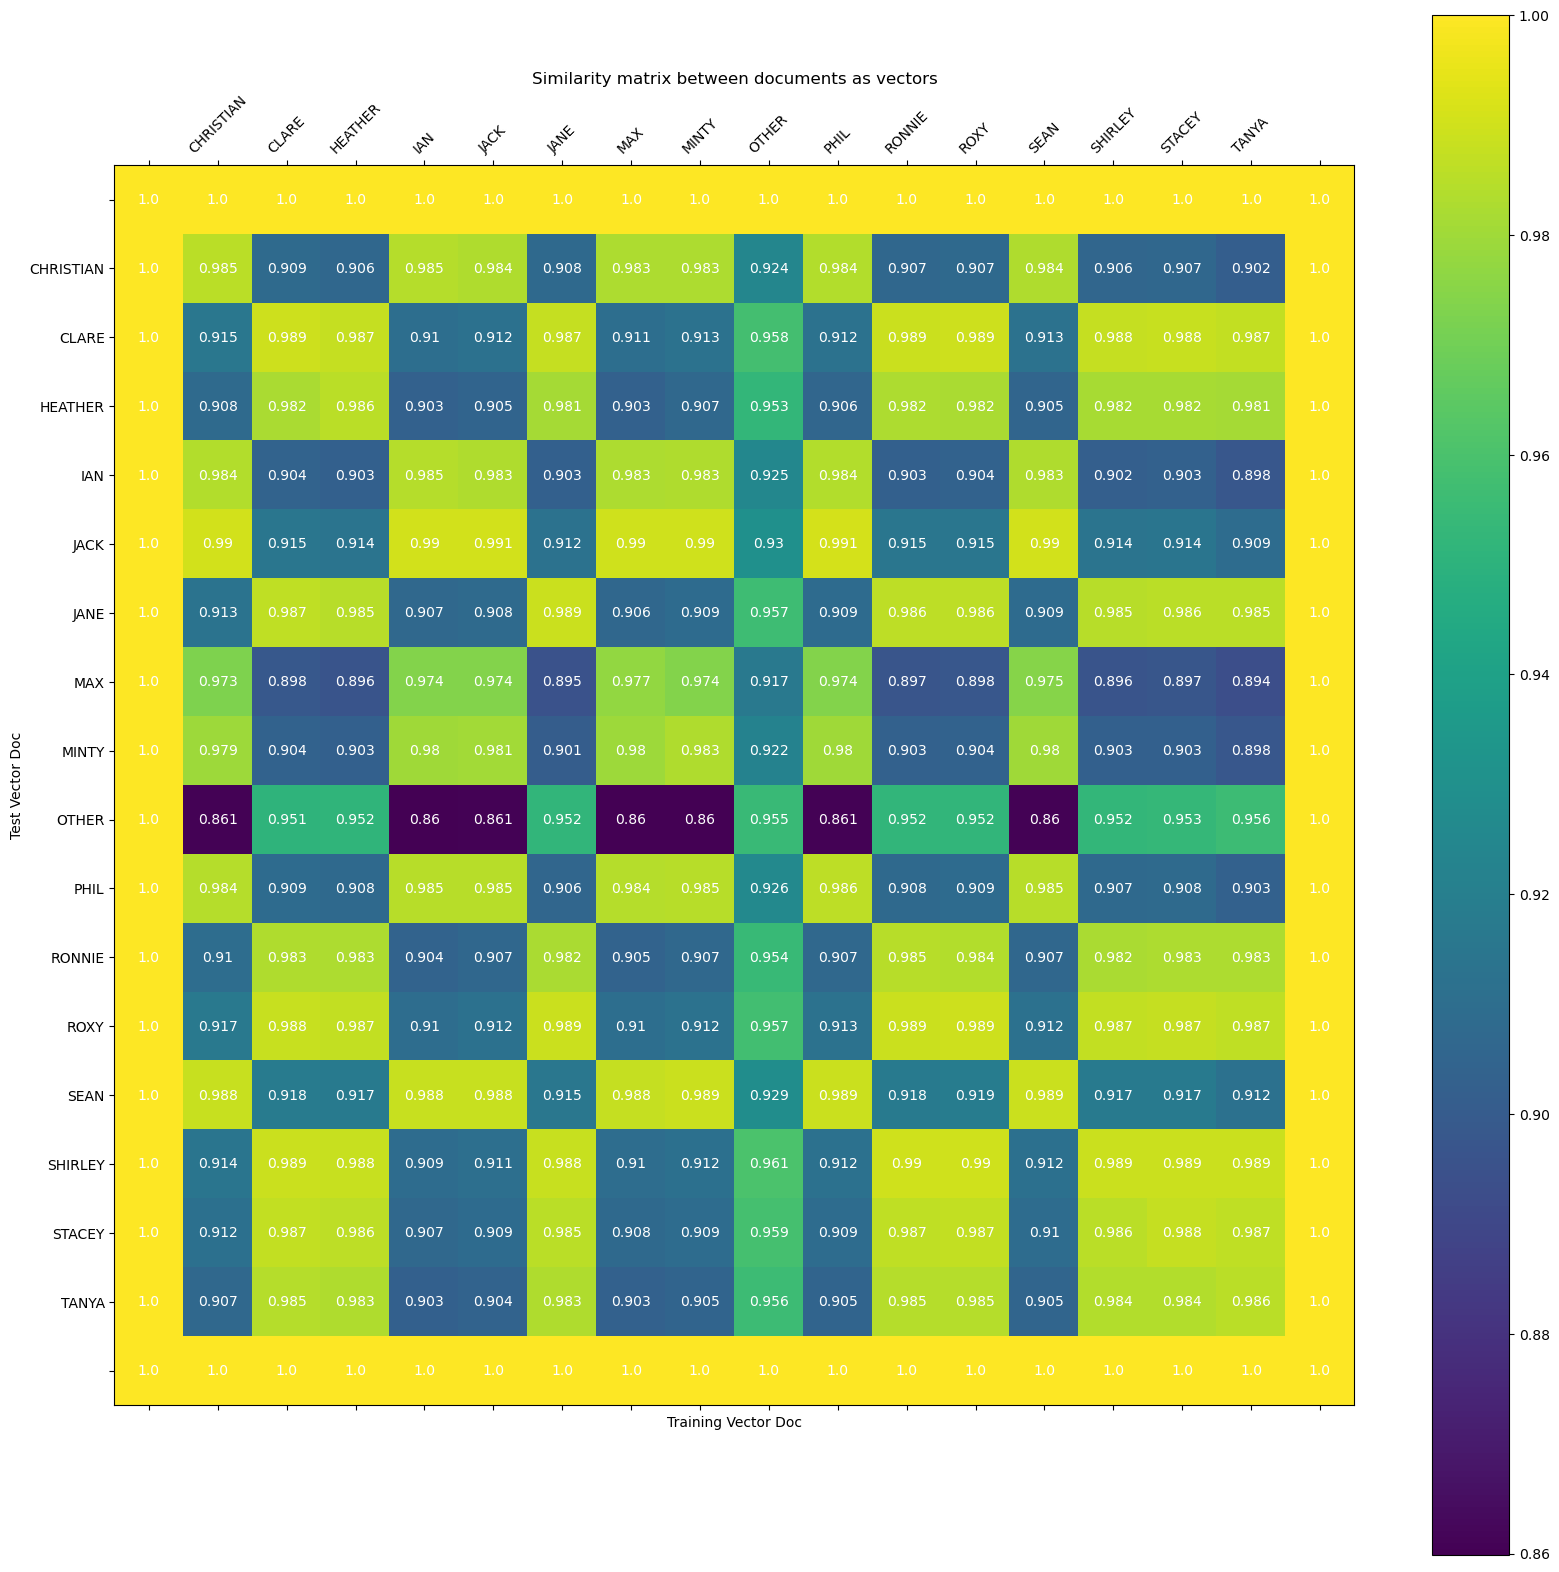

In [24]:
## take note of diagonal line
plot_heat_map_similarity(df_val_container[df_key])

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on all of the training data (using the first 400 lines per character maximum) and do the final testing on the test file (using the first 40 lines per character maximum).

Make any neccessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank, accuracy of document selection are on the test data.

In [25]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = DictVectorizer()   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# create episode scene column
epsiode_scene_column_test_data = test_data.Episode.astype(str) + "-" + test_data.Scene.astype(str)
test_data['episode_scene'] = epsiode_scene_column_test_data

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'SHIRLEY': 400, 'OTHER': 400, 'JACK': 400, 'RONNIE': 400, 'TANYA': 400, 'SEAN': 400, 'ROXY': 400, 'HEATHER': 400, 'MAX': 400, 'IAN': 400, 'JANE': 400, 'STACEY': 400, 'PHIL': 400, 'MINTY': 400, 'CHRISTIAN': 385, 'CLARE': 400}
Num. Characters:  16 

SHIRLEY Number of Words:  6756
OTHER Number of Words:  5317
JACK Number of Words:  7309
RONNIE Number of Words:  6394
TANYA Number of Words:  6606
SEAN Number of Words:  6560
ROXY Number of Words:  6743
HEATHER Number of Words:  7040
MAX Number of Words:  7594
IAN Number of Words:  7324
JANE Number of Words:  6612
STACEY Number of Words:  6848
PHIL Number of Words:  6632
MINTY Number of Words:  6931
CHRISTIAN Number of Words:  6762
CLARE Number of Words:  7377
total words 108805
lines per character {'SHIRLEY': 40, 'OTHER': 40, 'HEATHER': 40, 'PHIL': 40, 'SEAN': 40, 'TANYA': 40, 'MAX': 40, 'JACK': 40, 'IAN': 40, 'JANE': 40, 'STACEY': 40, 'ROXY': 40, 'RONNIE': 40, 'CHRISTIAN': 40, 'MINTY': 40, 'CLARE': 40}
Num. Characters: 

In [26]:
mean_rank, mean_cosine_simliarity, acc

(1.0, 0.9859031002080301, 1.0)

In [27]:
print(f'Results after improvement:\nMean rank: {mean_rank}')
print(f'Mean cosine similarity: {mean_cosine_simliarity}')
correct = int(len(val_labels)*acc)
print(f'{correct} correct out of {len(val_labels)} --> Accuracy: {acc}')

initial_mean_rank = 4.5
print(f'\nInitial mean rank: {initial_mean_rank}')
percentage_improvement = ((initial_mean_rank - mean_rank)/initial_mean_rank)*100
print(f'Percentage improvement of mean rank: {round(percentage_improvement,2)}%')

Results after improvement:
Mean rank: 1.0
Mean cosine similarity: 0.9859031002080301
16 correct out of 16 --> Accuracy: 1.0

Initial mean rank: 4.5
Percentage improvement of mean rank: 77.78%


/tmp/ipykernel_1994/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_1994/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_1994/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_1994/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_1994/932186355.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
/tmp/ipykernel_1994/932186355.py:10: Use

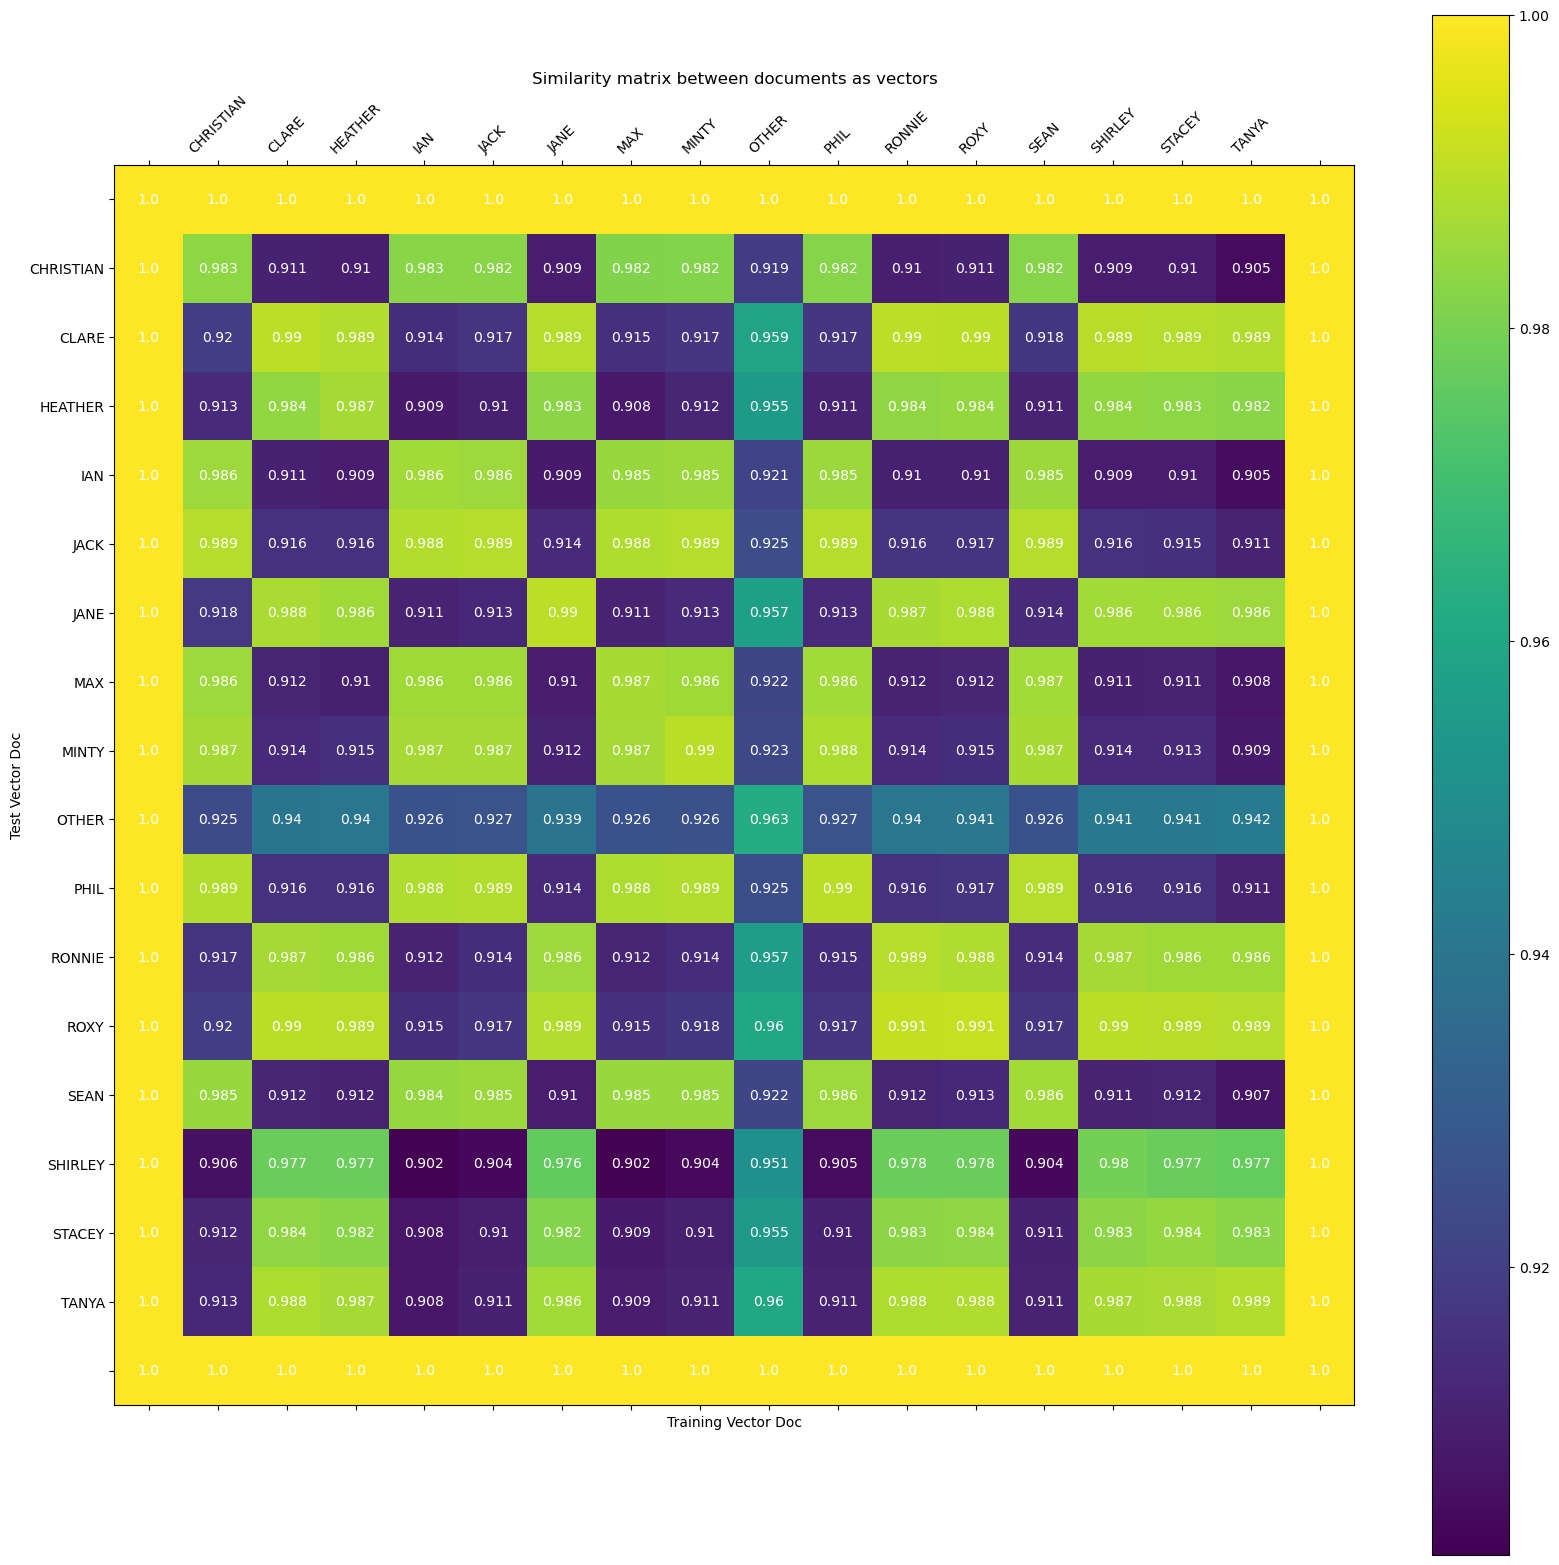

In [28]:
## take note of diagonal line
plot_heat_map_similarity(df)